## Project 3: Web Api's and NLP 

## Problem Statement:
The marketing department for a liberal arts college needs to increase student enrollment for their Psychology and Anthropology departments. These study disciplines share many similarities, therefore they need distinctive keywords to differentiate their marketing campaigns to increase enrollment.  
As a data scientist for the college, I need to find the most predictive words/phrases that help classify psychology and anthropology using subreddit posts as a resource.
	

In [112]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import time
import matplotlib as plt
import plotly_express as px
import seaborn as sns


# Preprocessing and Modeling

In [2]:
# Read in both cleaned dataframes
anthropology = pd.read_csv('./data/anthropology_cleaned.csv')
psychology = pd.read_csv('./data/psychology_cleaned.csv')

### Dropped Unnamed columns and merged anthropology and psychology dataframes

In [3]:
anthropology.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
psychology.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
merged_df = pd.concat([anthropology, psychology])

In [6]:
merged_df.head(5)

,body,subreddit,author,created_utc,body_length,body_word_count
0,"This all seems really helpful, thank you so much!",AskAnthropology,2npii,1634586224,49,9
1,Adrienne Meyer has done quite a bit of researc...,AskAnthropology,umbrabates,1634580081,1283,199
2,&gt;Grave Matters: A Lively History of Death A...,AskAnthropology,Cryptayy,1634576037,201,33
3,&gt; I was also thinking about the books from ...,AskAnthropology,twiggez-vous,1634575441,272,47
4,"In England, there were specific laws about thi...",AskAnthropology,dokh,1634573321,706,121


In [7]:
#Using tokenizer to further clean merged dataframe
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [8]:
merged_df['token_body'] = merged_df['body'].apply(tokenizer.tokenize)

In [9]:
merged_df['token_body']

0        [This, all, seems, really, helpful, ,, thank, ...
1        [Adrienne, Meyer, has, done, quite, a, bit, of...
2        [&gt;Grave, Matters, :, A, Lively, History, of...
3        [&gt;, I, was, also, thinking, about, the, boo...
4        [In, England, ,, there, were, specific, laws, ...
                               ...                        
24995    [Any, recommendation, to, sources, (books,, po...
24996    [What, they, mean, by, it, is, it, 's, dangero...
24997    [I, feel, the, same, way, about, Pride, in, To...
24998    [Is, there, a, term, for, when, ,, in, an, arg...
24999    [A, word, itself, is, empty, ., It, forms, mea...
Name: token_body, Length: 50000, dtype: object

## Preprocessing

In [68]:
#this function takes a list of words and preprocesses them for modeling using CountVectorizer()
def get_top_n_words(corpus, n=None):
    cvec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = cvec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#code adapted from https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

### The most repeated words for both subreddits are very similar.

In [69]:
#Getting the top 25 words from r/anthropology
common_words = get_top_n_words(anthropology['body'], 25)
for word, freq in common_words:
    anth_words = (word, freq)
    print(word,freq)

people 8958
like 7055
https 6218
just 5971
think 4846
don 4582
time 4167
know 4061
anthropology 3999
really 3571
gt 3483
different 3451
com 3216
human 3215
way 3210
question 3190
www 3170
culture 3157
years 3133
work 3111
good 2812
lot 2776
ve 2700
say 2669
modern 2641


In [30]:
#Getting the top 25 words from r/psychology
common_words = get_top_n_words(psychology['body'], 25)
for word, freq in common_words:
    psy_words = (word,freq)
    print(word, freq)

people 6772
like 4959
just 4549
https 4107
don 3636
think 3299
study 2711
message 2668
com 2653
questions 2468
know 2431
time 2294
feel 2221
psychology 2198
research 2170
moderators 1994
thank 1949
ve 1933
way 1914
really 1911
amp 1898
does 1886
good 1880
submission 1801
www 1799


### Building DataFrame for r/AskAnthropology 'words' and r/psychology 'words'

In [80]:
anth_list =['people', 'like','https','just','think','don','time','know','anthropology','really','gt','different','com','human','way','question','www','culture','years','work','good','lot','ve','say','modern']

In [81]:
anth_list=pd.DataFrame(anth_list)

In [82]:
number_anth = [8958,7055,6218,5971,4846,4582,4167,4061,3999,3571,3483,3451,3216,3215,3210,3190,3170,3157,3133,3111,2812,2776,2700,2669,2641,]

In [83]:
number_anth = pd.DataFrame(number_anth)

In [84]:
anth_list.insert(loc=1,column='number',value=number_anth)

In [87]:
psy_list = ['people','like','just','https','don','think','study','message','com','questions','know','time','feel','psychology','research','moderators','thank','ve','way','really','amp','does','good','submission','www']

In [88]:
psy_list=pd.DataFrame(psy_list)

In [89]:
number_psy = [6772,4959,4549,4107,3636,3299,2711,2668,2653,2468,2431,2294,2221,2198,2170,1994,1949,1933,1914,1911,1898,1886,1880,1801,1799]

In [90]:
number_psy = pd.DataFrame(number_psy)

In [91]:
psy_list.insert(loc=1,column='number', value=number_psy)

## Here are the top 25 words for r/AskAnthropology and r/psychology

[Text(0, 0.5, 'AskAnthropology Words'),
 Text(0.5, 1.0, 'Top 25 words for AskAnthropology')]

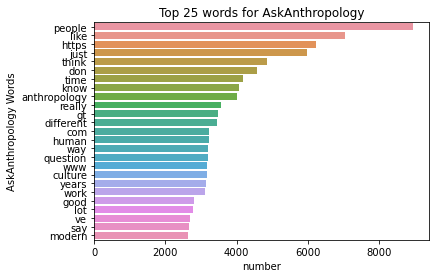

In [113]:
#Top 25 words anth unique words include: 'culture','years','modern','anthropology'
sns.barplot(data=anth_list, x='number', y=0,).set(ylabel='AskAnthropology Words',title='Top 25 words for AskAnthropology')



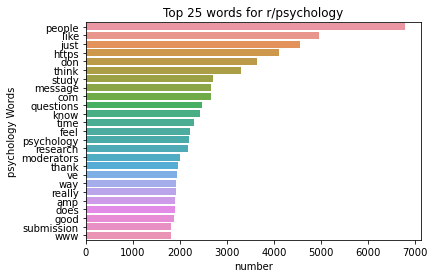

In [96]:
#Top 25 r/psychology uniques words include: 'study','message','feel','psychology','research','moderators','submission'
sns.barplot(data=psy_list, x='number', y=0).set(ylabel='psychology Words', title='Top 25 words for r/psychology');

In [14]:
# merged_df['subreddit'] = merged_df['subreddit'].map({'AskAnthropology': 0, 'psychology': 1})
# this step was not necessary to run the models below, so they are commented out

In [15]:
merged_df['subreddit'].value_counts()

psychology         25000
AskAnthropology    25000
Name: subreddit, dtype: int64

## MODELING

## Base Case

#### Since both subreddits are equally distributed (25_000 comments from each), the <b>base case</b> model would be 50%. Below we will see how much we can imporve from here.

In [10]:
#split our subreddit data into X and Y.
X = merged_df['body']
y = merged_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42, stratify=y)

In [11]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

cv_text = cv.transform(X_train)
# remember to use .todense() to de-sparsify the count vectorized text
cv_text_df = pd.DataFrame(cv_text.todense(), columns=cv.get_feature_names())

## Comparing models

In [18]:
%%time
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegressionCV(solver='liblinear', max_iter=500))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

CPU times: user 21min 41s, sys: 17.5 s, total: 21min 59s
Wall time: 5min 48s


(0.9261866666666667, 0.86456)

In [19]:
%%time
pipe = Pipeline([
    ('cv', TfidfVectorizer()),
    ('lr', LogisticRegressionCV(solver='liblinear'))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

CPU times: user 6min 17s, sys: 4.2 s, total: 6min 21s
Wall time: 1min 40s


(0.9272, 0.86992)

In [20]:
%%time
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

CPU times: user 4.61 s, sys: 112 ms, total: 4.72 s
Wall time: 4.75 s


(0.8711733333333334, 0.8496)

In [21]:
%%time
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

CPU times: user 4.74 s, sys: 115 ms, total: 4.86 s
Wall time: 4.88 s


(0.8980533333333334, 0.86112)

### Random Forest Model

In [22]:
X = merged_df['token_body']
y = merged_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42, stratify=y)

In [23]:
rf = RandomForestClassifier(n_estimators=100)

In [24]:
et = ExtraTreesClassifier(n_estimators=100)

In [25]:
cross_val_score(rf, cv_text, y_train, cv=5).mean()

0.8092

In [26]:
%%time
cross_val_score(et, cv_text, y_train, cv=5).mean()

CPU times: user 10min 2s, sys: 5.22 s, total: 10min 7s
Wall time: 10min 13s


0.82552

## Conclusion/Recommendation

Based on the findings from the data, the reddit posting show a close similarity with psychology and anthropology.  The differences in keywords for psychology included: study, message,feel, psychology, research. Anthropology keywords include: different, human,culture,lot(?),say, and modern. It is recommended to target ads for psychology using emotion words similar to ‘feel’.  Also to use keywords that appeal to an audience looking to do more research and study. For Anthropology, try to highlight ‘different’ cultures, and use language that shows the progression of humans from ancient to modern.

